# Chapter 6 - Learning Best Practices for Model Evaluation and Hyperparameter Tuning

<br>
<br>

In [1]:
from IPython.display import Image
%matplotlib inline

## Loading the Breast Cancer Wisconsin dataset

In [2]:
import pandas as pd

df = pd.read_csv('wdbc.data', header=None)
df.head()# (569,30)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
from sklearn.preprocessing import LabelEncoder

#特徵從[2]~,共30
X = df.loc[:, 2:].values
#標簽[1]
y = df.loc[:, 1].values
#['B', 'M']=> [良，惡]
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_ #原始內容

array(['B', 'M'], dtype=object)

In [4]:
le.transform(['M', 'B'])#轉換成[1, 0]

array([1, 0])

In [5]:
import numpy as np

# 原始標簽中，0,1 的數量
print(np.bincount(y))

[357 212]


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(X_train, y_train)

scores = []

#將kfold切好的10份，逐次配對train, test，一組一組取出
for k, (train, test) in enumerate(kfold):
    #針對每一組分配的train進行計算
    pipe_lr.fit(X_train[train], y_train[train])
    #針對每一組分配的test進行預測
    score = pipe_lr.score(X_train[test], y_train[test])
    
    scores.append(score)
    
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


<br>
<br>

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               #將455劃分10刻度，依次取出訓練(10%,20%,30%...)
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               #取出的部分再切10等分
                               cv=10,
                               n_jobs=1)

## Tuning hyperparameters via grid search 

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [12]:
clf = gs.best_estimator_

clf.fit(X_train, y_train)
# Note that the line above is not necessary, because
# the best_estimator_ will already be refit to the complete
# training set because of the refit=True setting in GridSearchCV
# (refit=True by default). Thanks to a reader, German Martinez,
# for pointing it out.

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


<br>
<br>

In [13]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [14]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy: 0.934 +/- 0.016


# Looking at different performance evaluation metrics

## Reading a confusion matrix

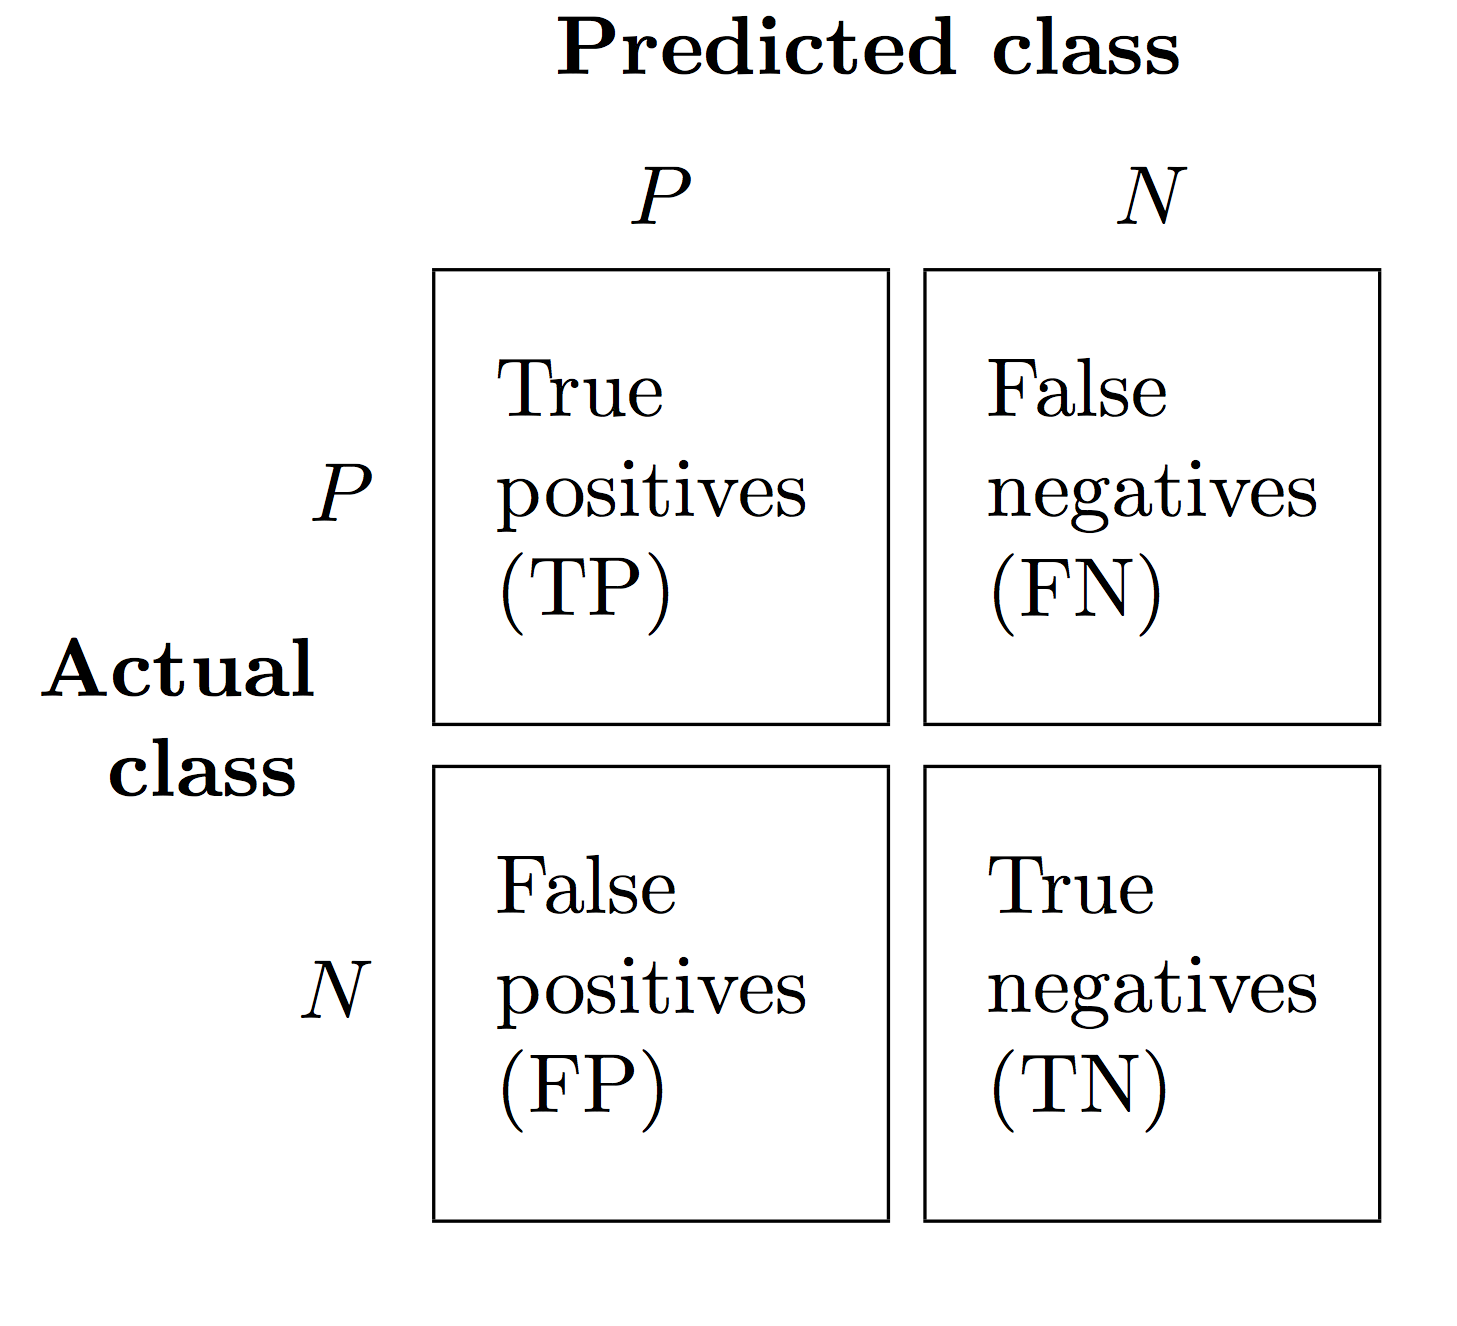

In [15]:
Image(filename='images/06_08.png', width=300) 

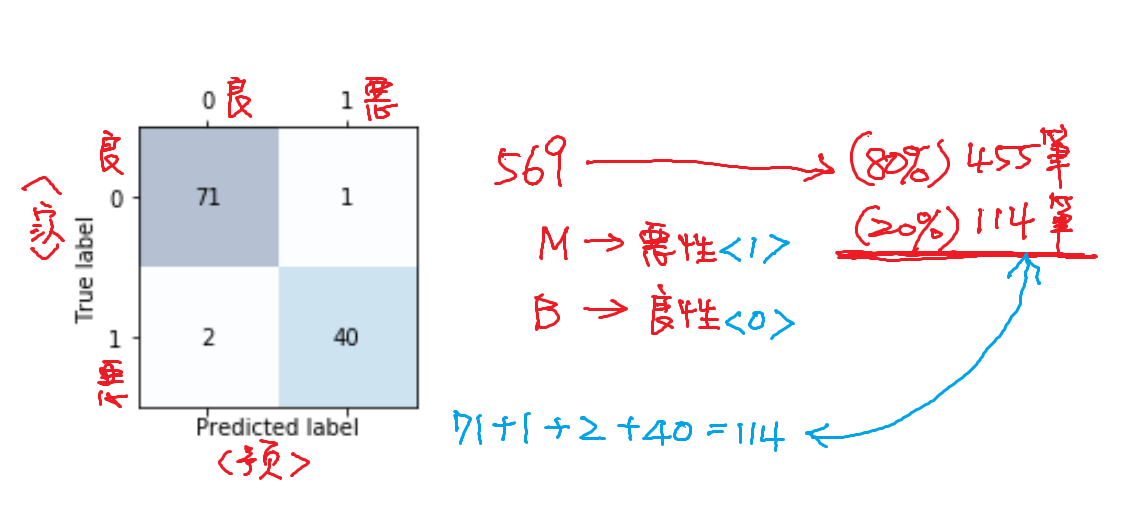

In [16]:
Image(filename='images/06_11.png', width=500) 

In [15]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


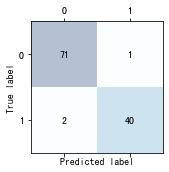

In [16]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

### Additional Note

Remember that we previously encoded the class labels so that *malignant* samples are the "postive" class (1), and *benign* samples are the "negative" class (0):

In [17]:
le.transform(['M', 'B'])

array([1, 0])

In [18]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Next, we printed the confusion matrix like so:

In [21]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Note that the (true) class 0 samples that are correctly predicted as class 0 (true negatives) are now in the upper left corner of the matrix (index 0, 0). In order to change the ordering so that the true negatives are in the lower right corner (index 1,1) and the true positves are in the upper left, we can use the `labels` argument like shown below:

In [19]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


We conclude:

Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified 71 of the samples that belong to class 0 (true negatives) and 40 samples that belong to class 1 (true positives), respectively. However, our model also incorrectly misclassified 1 sample from class 0 as class 1 (false positive), and it predicted that 2 samples are benign although it is a malignant tumor (false negatives).

<h1>----------------------------------------------------</h1>

## Optimizing the precision and recall of a classification model

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_test,y_pred))#真實,預測
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


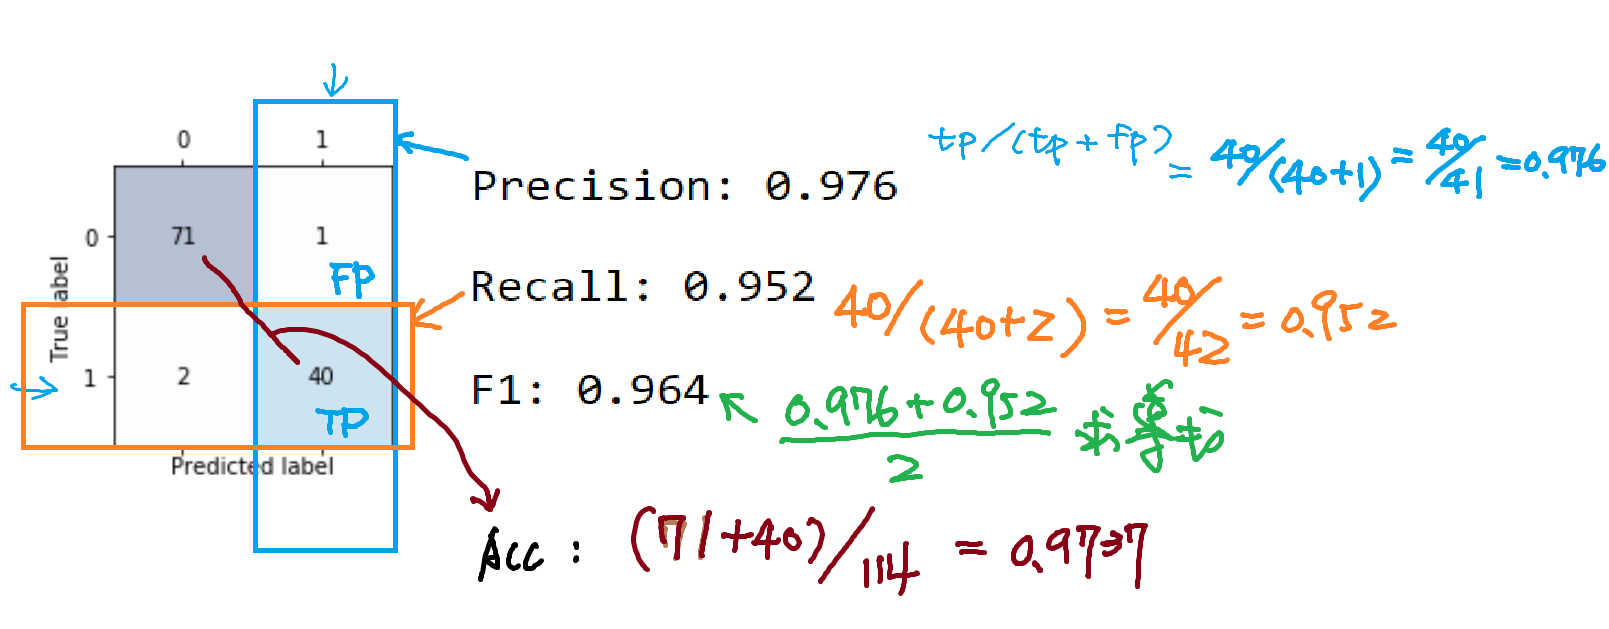

In [24]:
Image(filename='images/06_12.png', width=600) 

In [21]:
# 補充:

from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred,digits = 4))#真實,預測

              precision    recall  f1-score   support

           0     0.9726    0.9861    0.9793        72
           1     0.9756    0.9524    0.9639        42

    accuracy                         0.9737       114
   macro avg     0.9741    0.9692    0.9716       114
weighted avg     0.9737    0.9737    0.9736       114



In [22]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


<br>
<br>

## Plotting a receiver operating characteristic

[參考網址](https://www.itread01.com/content/1506927598.html)

[參考網址](https://ithelp.ithome.com.tw/articles/10229049?sc=rss.qu)

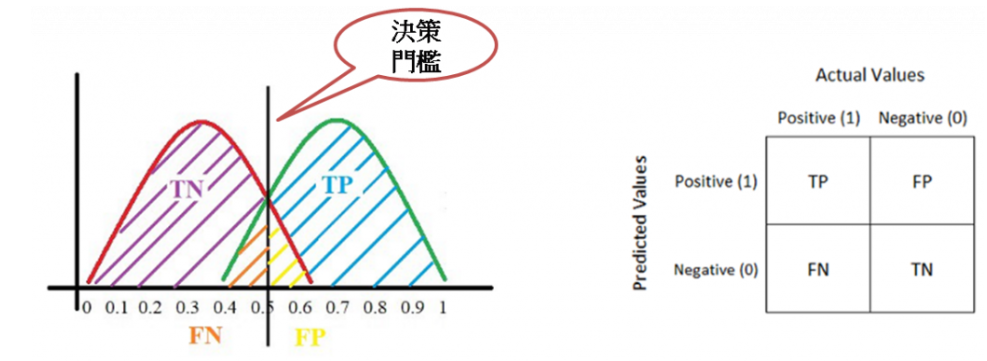

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
<ipython-input-23-b2d23ecc46dd>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-23-b2d23ecc46dd>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-23-b2d23ecc46dd>:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


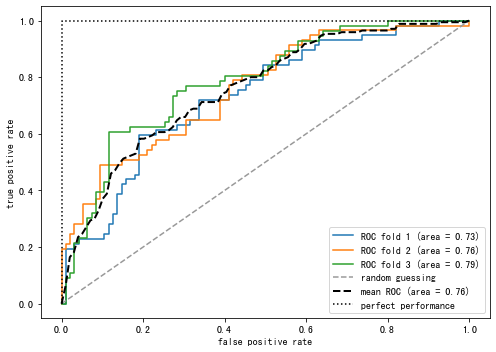

In [23]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1, 
                                           C=100.0))
# 取2特徵
X_train2 = X_train[:, [4, 14]]
    
# 切3份(包含：train+test)
cv = list(StratifiedKFold(n_splits=3, 
                          random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)# 100刻度點
all_tpr = []

for i, (train, test) in enumerate(cv):
    #probas = 152筆資料,預測為 0 / 1 的機率 = [預測為 0 的機率,預測為 1 的機率]
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    # 返回array:fpr, tpr,閾值
    fpr, tpr, thresholds = roc_curve(y_train[test],#真實結果
                                     probas[:, 1],#預測為 1 的機率
                                     pos_label=1)#把1當成positive
    
    #計算內差，針對每一組fpr(X), tpr(Y)補足100個座標點，並累加到mean_tpr
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    # 求面積
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
# 45角線
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# 繪製黑色線(mean)
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

# perfec line
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

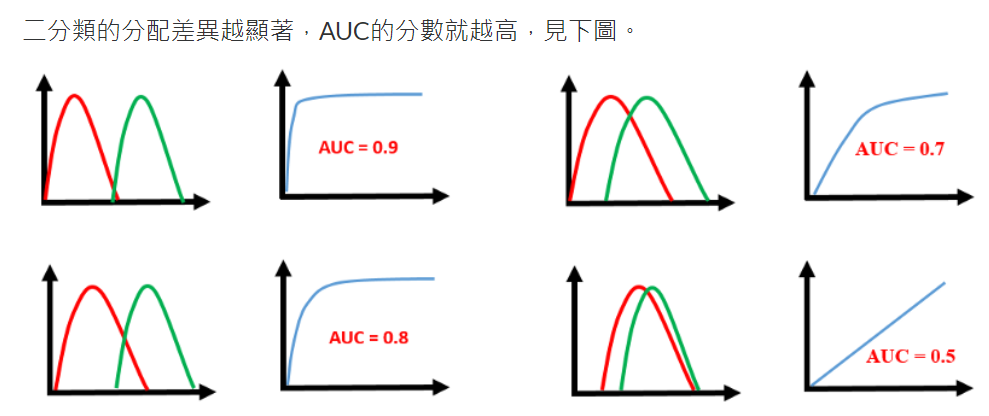

<br>
<br>

## The scoring metrics for multiclass classification

In [28]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

## Dealing with class imbalance

In [29]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

In [30]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [31]:
from sklearn.utils import resample

print('Number of class 1 samples before:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('Number of class 1 samples after:', X_upsampled.shape[0])

Number of class 1 samples before: 40
Number of class 1 samples after: 357


In [32]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [33]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

<br>
<br>

# Summary

...